#                                         Course: Deep Learning
### Name: SAYEDPEDRAM HAERI BOROUJENI
### Instructor: Dr. Feng Luo
### Home Work: Number One
### Part 3: Generalization

## 1. Import My Packages 

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transformtransforms
import torchvision.transforms.functional as TF
from torchvision import models
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import cv2
import copy
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
TORCH_CUDA_ARCH_LIST="8.6"

Project_PATH = os.path.dirname(os.path.abspath('__file__'))
outputs_dir = Project_PATH + '/Desktop/Deep Learning HW1/'
model_path = Project_PATH + '/save_models/'

## 2. My Device 

In [2]:
device_default = torch.cuda.current_device()
torch.cuda.device(device_default)
device = torch.device("cuda")
print("torch.cuda.is_available:", torch.cuda.is_available())
print("torch.cuda.device_count:", torch.cuda.device_count())
print("torch.cuda.current_device:", torch.cuda.current_device())
print("torch.cuda.get_device_name:", torch.cuda.get_device_name(device_default))
print("torch.version.cuda:", torch.version.cuda)
print("torch.version:", torch.__version__)
print("torch.cuda.arch_list:", torch.cuda.get_arch_list())

torch.cuda.is_available: True
torch.cuda.device_count: 1
torch.cuda.current_device: 0
torch.cuda.get_device_name: NVIDIA RTX A5000
torch.version.cuda: 11.3
torch.version: 1.11.0
torch.cuda.arch_list: ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']


## 3. My Model 

In [3]:
class DNN_MNIST_N(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, hidden_3, out_dim):
        super(DNN_MNIST_N, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, hidden_1),nn.BatchNorm1d(hidden_1),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(hidden_1, hidden_2),nn.BatchNorm1d(hidden_2),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(hidden_2, hidden_3),nn.BatchNorm1d(hidden_3),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.Linear(hidden_3, out_dim))
        
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        x = self.layer4(x)
        return x

class DNN_MNIST_3(nn.Module):
    def __init__(self):
        super(DNN_MNIST_3, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, 256),nn.BatchNorm1d(256),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(256, 128),nn.BatchNorm1d(128),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(128, 64),nn.BatchNorm1d(64),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.Linear(64, 32),nn.BatchNorm1d(32),nn.ReLU(True))
        self.layer5 = nn.Sequential(nn.Linear(32, 10))
        
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        x = self.layer4(x)    
        x = self.layer5(x)    
        return x

def standardization(x):
    x = np.array(x)
    x[np.isnan(x)] = 0
    return (x-np.mean(x))/np.std(x)

## 4. Train My Model 

In [4]:
# 1. Training Function
def train_shuffle(model_name,
                Epochs = 100,
                Batch  = 2000,
                Data_workers = 0,
                LR = 0.01):
    
# 2. Initialization 
    trainset = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
    testset = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())
    random.shuffle(trainset.train_labels)
    trainloader = DataLoader(trainset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(testset,  batch_size=Batch, shuffle=True, num_workers=Data_workers)
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)
    
# 3. Initialization model
    torch.cuda.is_available()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    Model = model_name.to(device)

# 4. loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.8)

# 5. Training
    trainloss_list = []
    testloss_list  = []
    accuracy_list  = []
    lr_list = []
   
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total = (i+1)*Batch

# 6. Evaluating
        Model.eval()
        with torch.no_grad():
            test_loss = 0
            correct = 0
            total = 0
            for data in testloader:
                images, labels = data
                images = (images.view(-1, 28*28)).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == labels).cpu().sum()
                total += labels.size(0)
            total = len(testloader.dataset)
            accuracy = 100.0*correct/total

# 7. Save loss 
        scheduler.step()
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        accuracy_list.append(accuracy)
        print('{}/{} Test set: Average loss: {:.4f}/{:.4f}, Accuracy: {}/{} ({:.2f}%) lr={}'.format(
                epoch, Epochs, train_loss,test_loss, correct, total, accuracy, lr_list[-1]))

    return [trainloss_list,
            testloss_list,
            accuracy_list,
            lr_list]

[trainloss_list,testloss_list,accuracy_list,lr_list] = train_shuffle(model_name=DNN_MNIST_3())

C:\Users\shaerib\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/100 Test set: Average loss: 70.5141/11.5723, Accuracy: 1047/10000 (10.47%) lr=0.01
1/100 Test set: Average loss: 68.9443/11.5841, Accuracy: 1104/10000 (11.04%) lr=0.01
2/100 Test set: Average loss: 68.4230/11.5959, Accuracy: 1149/10000 (11.49%) lr=0.01
3/100 Test set: Average loss: 68.0437/11.5819, Accuracy: 1205/10000 (12.05%) lr=0.01
4/100 Test set: Average loss: 67.6747/11.6196, Accuracy: 1212/10000 (12.12%) lr=0.008
5/100 Test set: Average loss: 67.2716/11.5437, Accuracy: 1349/10000 (13.49%) lr=0.008
6/100 Test set: Average loss: 66.9153/11.5734, Accuracy: 1247/10000 (12.47%) lr=0.008
7/100 Test set: Average loss: 66.5287/11.7064, Accuracy: 1153/10000 (11.53%) lr=0.008
8/100 Test set: Average loss: 66.1263/11.6283, Accuracy: 1252/10000 (12.52%) lr=0.008
9/100 Test set: Average loss: 65.6984/11.7695, Accura

## 5. Ploting and Visualization 

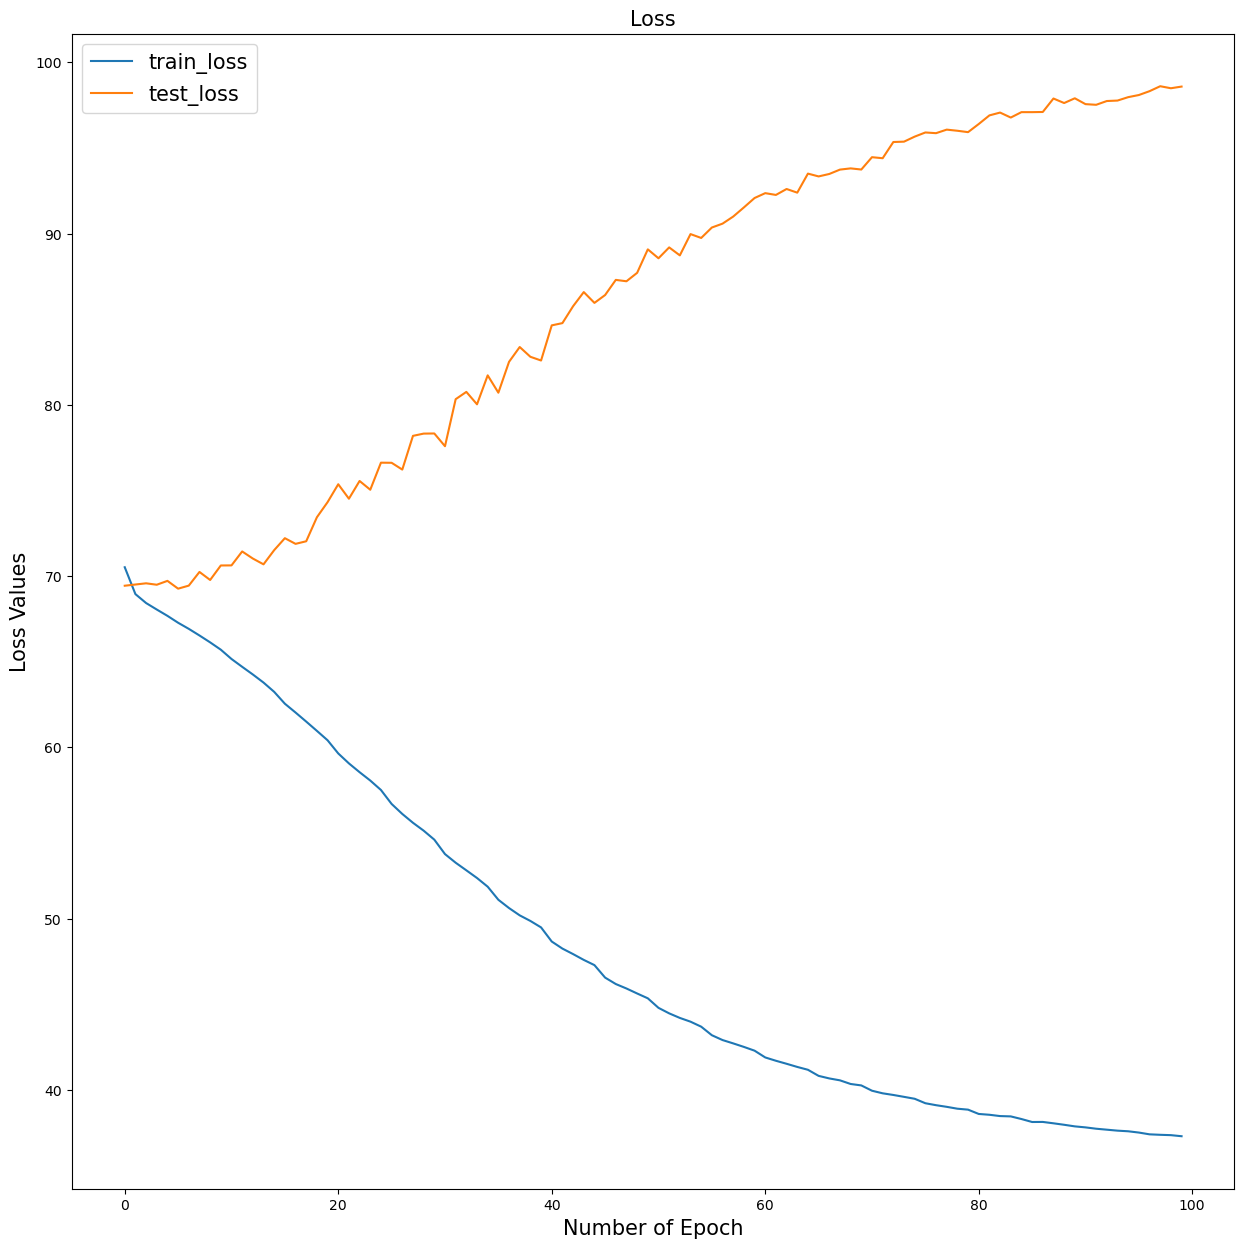

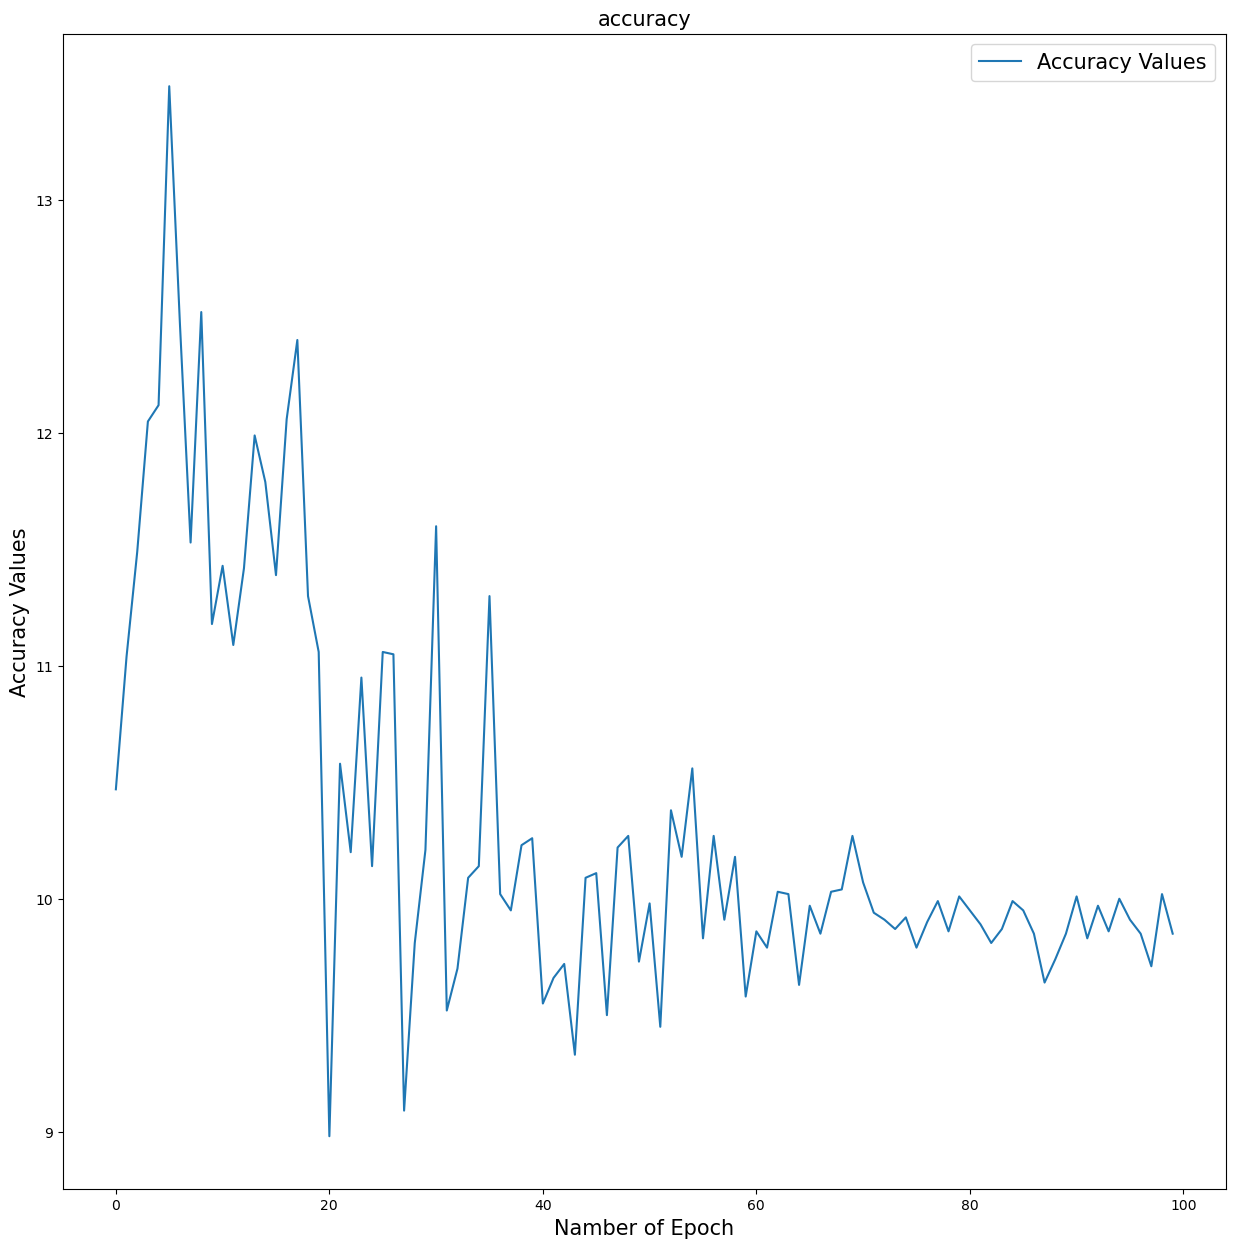

In [5]:
plt.figure(figsize=(15,15))
plt.plot(np.array(trainloss_list), label='train_loss')
plt.plot(np.array(testloss_list)*6, label='test_loss')
plt.xlabel('Number of Epoch',fontsize=15)
plt.ylabel('Loss Values',fontsize=15)
plt.title('Loss',fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(15,15))
plt.plot(accuracy_list, label='Accuracy Values')
plt.xlabel('Namber of Epoch',fontsize=15)
plt.ylabel('Accuracy Values',fontsize=15)
plt.title('accuracy',fontsize=15)
plt.legend(fontsize=15)
plt.show()

## 6. Generalization 

In [6]:
def train_CIFAR10(model_name, Epochs=20, Batch=2000, Data_workers=0, LR=0.1):

# 1. Load Dataset
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data/',train=True,download=True,transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data/',train=False,download=True,transform=transform)
    trainloader = DataLoader(trainset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(testset,  batch_size=Batch, shuffle=True, num_workers=Data_workers)
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)
    torch.cuda.is_available()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    Model = model_name.to(device)
    num_param = sum(param.numel() for param in Model.parameters())
    print(model_name)
    print('Number of total parameters: ', num_param)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.8)
    
# 2. Training
    trainloss_list = []
    testloss_list  = []
    train_acc_list  = []
    test_acc_list = []
    lr_list = []
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, data in enumerate(trainloader):
            images, labels = data
            images = (images.view(-1, 3*32*32)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            train_correct += (pred == labels).cpu().sum()
        train_total = len(trainloader.dataset)
        train_acc = 100.0*train_correct/train_total
        
# 3. Evaluation
        Model.eval()
        with torch.no_grad():
            test_loss = 0
            test_correct = 0
            test_total = 0
            for data in testloader:
                images, labels = data
                images = (images.view(-1, 3*32*32)).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                test_correct += (pred == labels).cpu().sum()
            test_total = len(testloader.dataset)
            test_acc = 100.0*test_correct/test_total

# 4. Save Loss
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('{}/{} Test set: Average loss: {:.4f}/{:.4f}, Accuracy: {}/{} ({:.2f}%)/({:.2f}%) lr={}'.format(
                epoch, Epochs, train_loss,test_loss, train_correct,test_correct, train_acc,test_acc, lr_list[-1]))

    return [trainloss_list, testloss_list,
            train_acc_list, test_acc_list,
            lr_list, num_param]

In [7]:
[trainloss_1,testloss_1,train_acc_1,test_acc_1,_,num_param_1] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,1,2,1,10),Epochs=100)
[trainloss_2,testloss_2,train_acc_2,test_acc_2,_,num_param_2] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,2,4,2,10),Epochs=100)
[trainloss_3,testloss_3,train_acc_3,test_acc_3,_,num_param_3] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,3,6,3,10),Epochs=100)
[trainloss_4,testloss_4,train_acc_4,test_acc_4,_,num_param_4] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,5,10,5,10),Epochs=100)
[trainloss_5,testloss_5,train_acc_5,test_acc_5,_,num_param_5] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,10,20,10,10),Epochs=100)
[trainloss_6,testloss_6,train_acc_6,test_acc_6,_,num_param_6] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,20,40,20,10),Epochs=100)
[trainloss_7,testloss_7,train_acc_7,test_acc_7,_,num_param_7] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,50,100,50,10),Epochs=100)
[trainloss_8,testloss_8,train_acc_8,test_acc_8,_,num_param_8] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,100,200,100,10),Epochs=100)
[trainloss_9,testloss_9,train_acc_9,test_acc_9,_,num_param_9] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,200,400,200,10),Epochs=100)
[trainloss_10,testloss_10,train_acc_10,test_acc_10,_,num_param_10] = train_CIFAR10(model_name=DNN_MNIST_N(3*32*32,500,1000,500,10),Epochs=100)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)
(10000, 32, 32, 3)
DNN_MNIST_N(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
  )
)
Number of total parameters:  3108
0/100 Test set: Average loss: 57.5763/11.2957, Acc

In [8]:
num_param_list = [num_param_1,num_param_2,num_param_3,num_param_4,num_param_5,num_param_6,num_param_7,num_param_8,num_param_9,num_param_10]

trainloss_list = [trainloss_1,trainloss_2,trainloss_3,trainloss_4,trainloss_5,trainloss_6,trainloss_7,trainloss_8,trainloss_9,trainloss_10]
trainloss = np.array(trainloss_list)[:,-1]
testloss_list = [testloss_1,testloss_2,testloss_3,testloss_4,testloss_5,testloss_6,testloss_7,testloss_8,testloss_9,testloss_10]
testloss = np.array(testloss_list)[:,-1]

train_acc_list = [train_acc_1,train_acc_2,train_acc_3,train_acc_4,train_acc_5,train_acc_6,train_acc_7,train_acc_8,train_acc_9,train_acc_10]
train_acc = np.array(train_acc_list)[:,-1]
test_acc_list = [test_acc_1,test_acc_2,test_acc_3,test_acc_4,test_acc_5,test_acc_6,test_acc_7,test_acc_8,test_acc_9,test_acc_10]
test_acc = np.array(test_acc_list)[:,-1]

## 7. Ploting and Visualization 

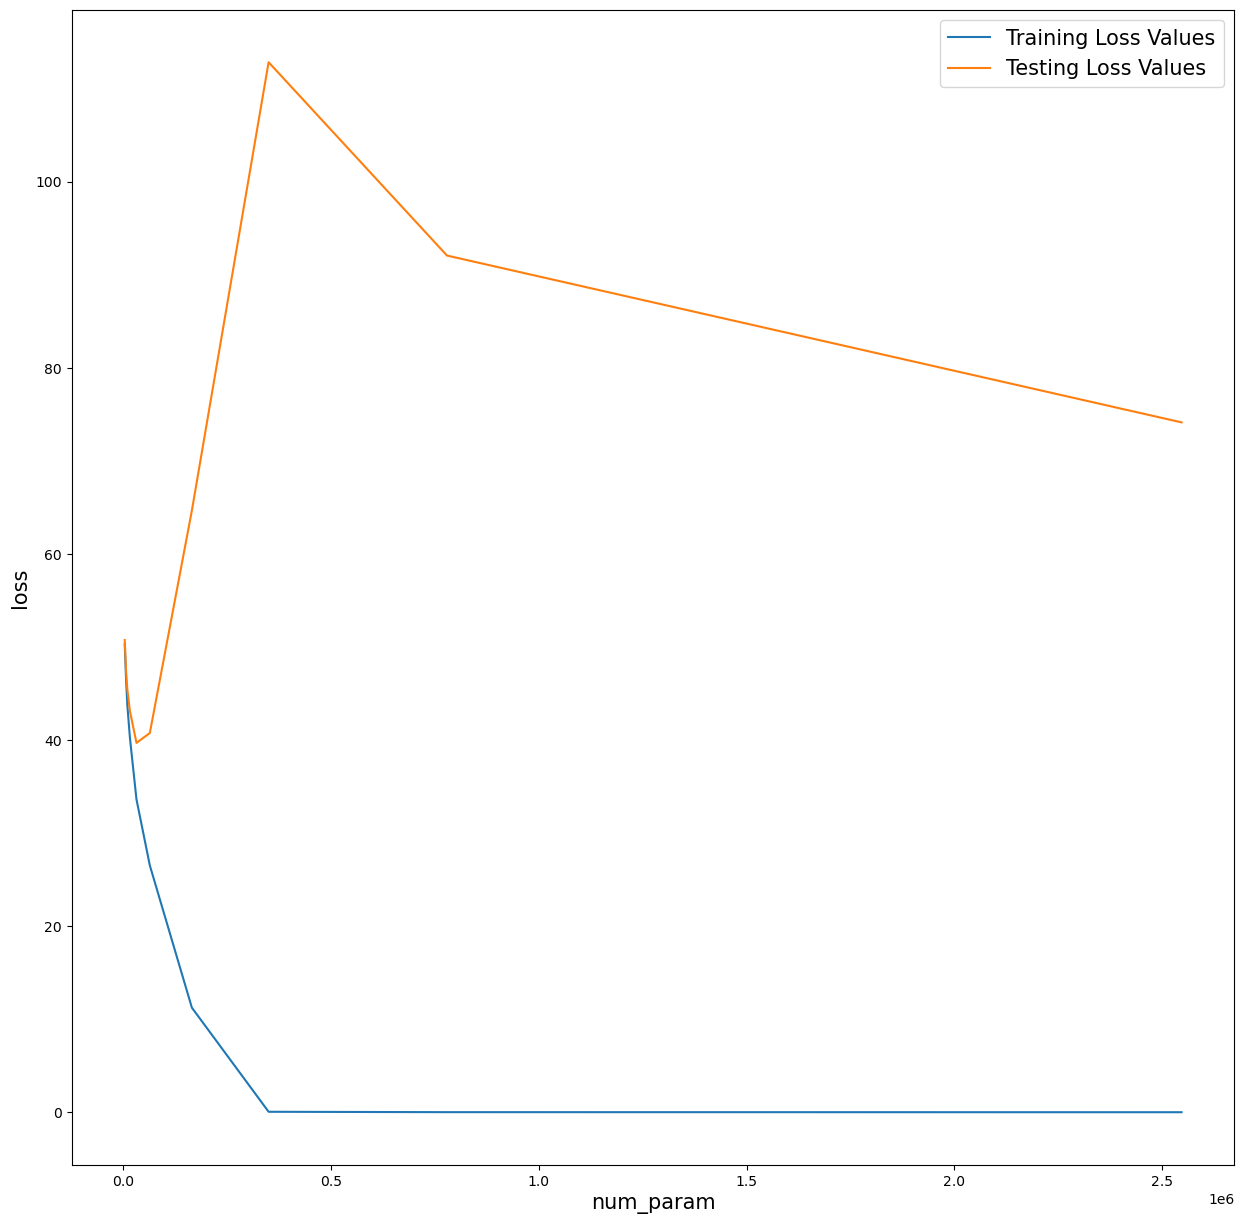

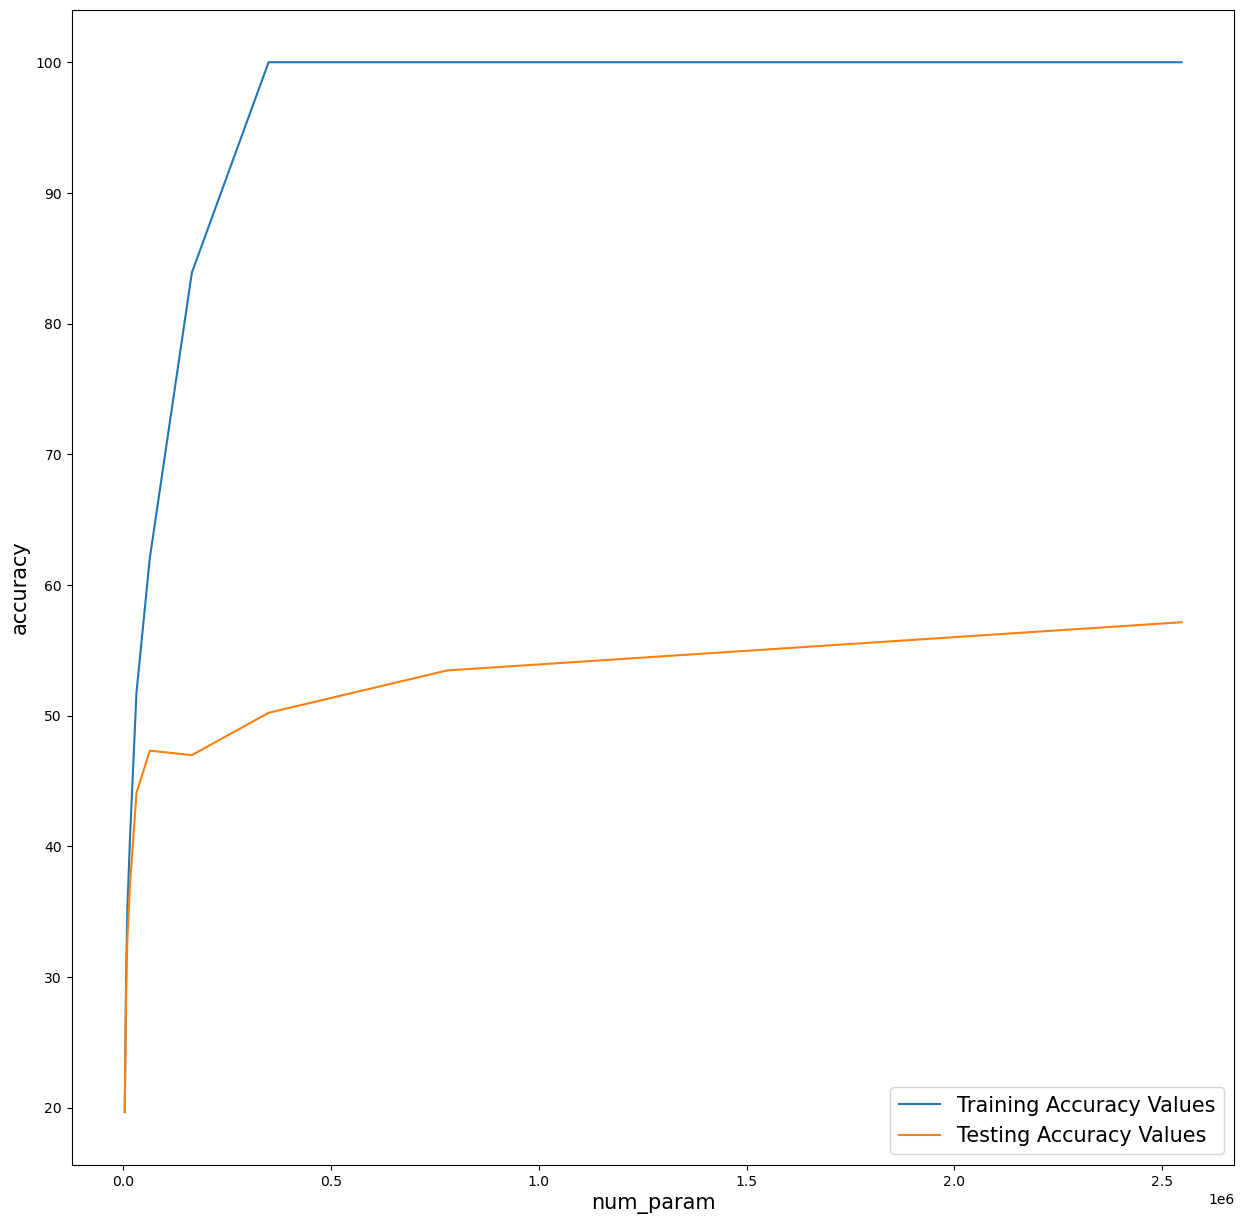

In [9]:
plt.figure(figsize=(15,15))
plt.plot((num_param_list), (trainloss), label='Training Loss Values')
plt.plot((num_param_list), (testloss*5), label='Testing Loss Values')
plt.xlabel('num_param',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(15,15))
plt.plot(num_param_list, train_acc, label='Training Accuracy Values')
plt.plot(num_param_list, test_acc, label='Testing Accuracy Values')
plt.xlabel('num_param',fontsize=15)
plt.ylabel('accuracy',fontsize=15)
plt.legend(fontsize=15)
plt.show()

## 8. Part1: Flatness v.s. Generalization 

In [10]:
# 1. Training Function
def train_MNIST(model_name,
                Epochs = 20,
                Batch  = 2000,
                Data_workers = 0,
                LR = 0.1):
    
# 2. Initialization
    train_set = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
    test_set = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())
    trainloader = DataLoader(train_set, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(test_set,  batch_size=Batch, shuffle=True, num_workers=Data_workers)
    print(train_set.classes)
    print(train_set.data.shape)
    print(test_set.data.shape)

# 3. Initialization Model
    torch.cuda.is_available()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    Model = model_name.to(device)

# 4. Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.8)

# 5. Training
    trainloss_list = []
    testloss_list  = []
    accuracy_list  = []
    lr_list = []
    F = []
   
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total = (i+1)*Batch

# 6. Evaluation
        Model.eval()
        with torch.no_grad():
            test_loss = 0
            correct = 0
            total = 0
            for data in testloader:
                images, labels = data
                images = (images.view(-1, 28*28)).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == labels).cpu().sum()
                total += labels.size(0)
            total = len(testloader.dataset)
            accuracy = 100.0*correct/total

# 7. Save Loss
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        accuracy_list.append(accuracy)
        print('{}/{} Test set: Average loss: {:.4f}/{:.4f}, Accuracy: {}/{} ({:.2f}%) lr={}'.format(
                epoch, Epochs, train_loss,test_loss, correct, total, accuracy, lr_list[-1]))

    return [Model,
            trainloss_list,
            testloss_list,
            accuracy_list,
            lr_list,
            F]

### 8. Part1.1: Batch = 64 vs Batch = 2048 

In [11]:
[Model_64,trainloss_64,testloss_64,accuracy_64,lr_64,_] = train_MNIST(model_name=DNN_MNIST_N(28*28,100,200,100,10),Batch=64)
[Model_2048,trainloss_2048,testloss_2048,accuracy_2048,lr_2048,_] = train_MNIST(model_name=DNN_MNIST_N(28*28,100,200,100,10),Batch=2048)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/20 Test set: Average loss: 207.0145/17.3169, Accuracy: 9687/10000 (96.87%) lr=0.1
1/20 Test set: Average loss: 100.5276/13.0820, Accuracy: 9765/10000 (97.65%) lr=0.1
2/20 Test set: Average loss: 74.3310/12.2023, Accuracy: 9751/10000 (97.51%) lr=0.1
3/20 Test set: Average loss: 60.2526/11.9346, Accuracy: 9776/10000 (97.76%) lr=0.1
4/20 Test set: Average loss: 49.3389/11.0850, Accuracy: 9794/10000 (97.94%) lr=0.1
5/20 Test set: Average loss: 42.0044/9.7915, Accuracy: 9806/10000 (98.06%) lr=0.1
6/20 Test set: Average loss: 36.4144/11.3653, Accuracy: 9792/10000 (97.92%) lr=0.1
7/20 Test set: Average loss: 30.9662/10.6907, Accuracy: 9800/10000 (98.00%) lr=0.1
8/20 Test set: Average loss: 28.4442/12.6325, Accuracy: 9781/10000 (97.81%) lr=0.1
9/20 Test set: Average loss: 26.2892/10.5030, Accuracy: 9811/10000 (98.11%)

### 8. Part1.2: Learning Rate  = 0.01 vs Learning Rate = 0.001 

In [12]:
[Model_1e3,trainloss_1e3,testloss_1e3,accuracy_1e3,lr_1e3,_] = train_MNIST(model_name=DNN_MNIST_N(28*28,100,200,100,10),LR=0.001)
[Model_1e2,trainloss_1e2,testloss_1e2,accuracy_1e2,lr_1e2,_] = train_MNIST(model_name=DNN_MNIST_N(28*28,100,200,100,10),LR=0.01)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/20 Test set: Average loss: 62.6735/9.8471, Accuracy: 5111/10000 (51.11%) lr=0.001
1/20 Test set: Average loss: 43.4908/6.1466, Accuracy: 7794/10000 (77.94%) lr=0.001
2/20 Test set: Average loss: 33.2672/4.7786, Accuracy: 8340/10000 (83.40%) lr=0.001
3/20 Test set: Average loss: 26.7201/3.9075, Accuracy: 8630/10000 (86.30%) lr=0.001
4/20 Test set: Average loss: 22.1768/3.2979, Accuracy: 8820/10000 (88.20%) lr=0.001
5/20 Test set: Average loss: 18.9577/2.8582, Accuracy: 8931/10000 (89.31%) lr=0.001
6/20 Test set: Average loss: 16.6248/2.5293, Accuracy: 9035/10000 (90.35%) lr=0.001
7/20 Test set: Average loss: 14.8586/2.2837, Accuracy: 9097/10000 (90.97%) lr=0.001
8/20 Test set: Average loss: 13.4973/2.0893, Accuracy: 9145/10000 (91.45%) lr=0.001
9/20 Test set: Average loss: 12.4102/1.9289, Accuracy: 9186/10000 (

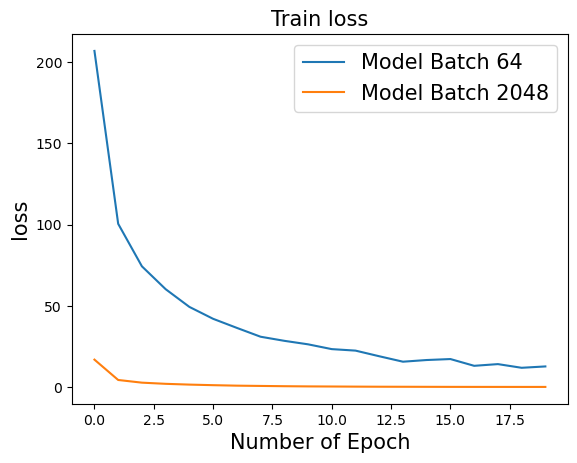

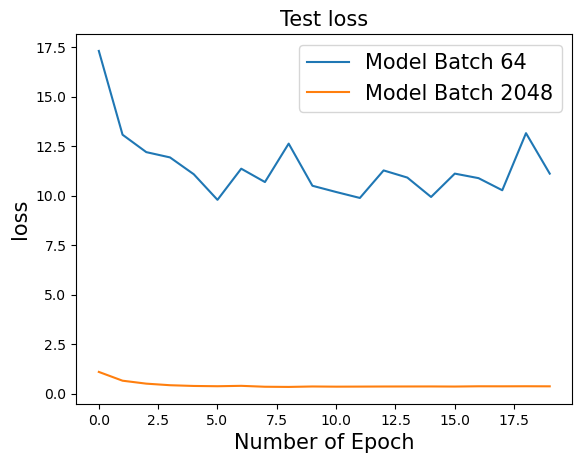

In [13]:
plt.figure()
plt.plot(trainloss_64, label='Model Batch 64')
plt.plot(trainloss_2048, label='Model Batch 2048')
plt.xlabel('Number of Epoch',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.title('Train loss',fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.figure()
plt.plot(testloss_64, label='Model Batch 64')
plt.plot(testloss_2048, label='Model Batch 2048')
plt.xlabel('Number of Epoch',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.title('Test loss',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [14]:
train_set = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
test_set = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())
trainloader = DataLoader(train_set, batch_size=2000, shuffle=True, num_workers=0)
testloader  = DataLoader(test_set,  batch_size=2000, shuffle=True, num_workers=0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Model = DNN_MNIST_N(28*28,100,200,100,10).to(device)
criterion = nn.CrossEntropyLoss()
param_1 = Model_64.state_dict()
param_2 = Model_2048.state_dict()

batch_train_loss = []
batch_test_loss = []
batch_train_acc = []
batch_test_acc = []

alpha_list = np.linspace(-2,2,50)
for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    param_new = {}
    for key in param_1.keys():
        param_new[key] = (1-alpha)*param_1[key] + alpha*param_2[key]
    Model.load_state_dict(param_new)
    Model.eval()
    with torch.no_grad():
        train_loss = 0
        correct = 0
        for data in trainloader:
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()
        total = len(trainloader.dataset)
        accuracy = 100.0*correct/total
        batch_train_loss.append(loss.detach().cpu().numpy())
        batch_train_acc.append(accuracy.detach().cpu().numpy())
        
        test_loss = 0
        correct = 0
        for data in testloader:
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()
        total = len(testloader.dataset)
        accuracy = 100.0*correct/total
        batch_test_loss.append(loss.detach().cpu().numpy())
        batch_test_acc.append(accuracy.detach().cpu().numpy())

    print(alpha)

-2.0
-1.9183673469387754
-1.836734693877551
-1.7551020408163265
-1.6734693877551021
-1.5918367346938775
-1.510204081632653
-1.4285714285714286
-1.3469387755102042
-1.2653061224489797
-1.183673469387755
-1.1020408163265307
-1.0204081632653061
-0.9387755102040818
-0.8571428571428572
-0.7755102040816328
-0.6938775510204083
-0.6122448979591837
-0.5306122448979593
-0.44897959183673475
-0.3673469387755104
-0.2857142857142858
-0.20408163265306145
-0.12244897959183687
-0.04081632653061229
0.04081632653061229
0.12244897959183643
0.204081632653061
0.2857142857142856
0.36734693877551017
0.4489795918367343
0.5306122448979589
0.6122448979591835
0.693877551020408
0.7755102040816326
0.8571428571428568
0.9387755102040813
1.020408163265306
1.1020408163265305
1.1836734693877546
1.2653061224489792
1.3469387755102038
1.4285714285714284
1.510204081632653
1.591836734693877
1.6734693877551017
1.7551020408163263
1.8367346938775508
1.9183673469387754
2.0


In [15]:
train_set = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
test_set = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())
trainloader = DataLoader(train_set, batch_size=2000, shuffle=True, num_workers=0)
testloader  = DataLoader(test_set,  batch_size=2000, shuffle=True, num_workers=0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Model = DNN_MNIST_N(28*28,100,200,100,10).to(device)
criterion = nn.CrossEntropyLoss()
param_1 = Model_1e3.state_dict()
param_2 = Model_1e2.state_dict()

lr_train_loss = []
lr_train_acc = []
lr_test_loss = []
lr_test_acc = []

alpha_list = np.linspace(0,1,50)
for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    param_new = {}
    for key in param_1.keys():
        param_new[key] = (1-alpha)*param_1[key] + alpha*param_2[key]
    Model.load_state_dict(param_new)
    Model.eval()
    with torch.no_grad():
        train_loss = 0
        correct = 0
        for data in trainloader:
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()
        total = len(trainloader.dataset)
        accuracy = 100.0*correct/total
        lr_train_loss.append(loss.detach().cpu().numpy())
        lr_train_acc.append(accuracy.detach().cpu().numpy())
        
        test_loss = 0
        correct = 0
        for data in testloader:
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()
        total = len(testloader.dataset)
        accuracy = 100.0*correct/total
        lr_test_loss.append(loss.detach().cpu().numpy())
        lr_test_acc.append(accuracy.detach().cpu().numpy())

    print(alpha)

0.0
0.02040816326530612
0.04081632653061224
0.061224489795918366
0.08163265306122448
0.1020408163265306
0.12244897959183673
0.14285714285714285
0.16326530612244897
0.18367346938775508
0.2040816326530612
0.22448979591836732
0.24489795918367346
0.26530612244897955
0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464
0.4693877551020408
0.4897959183673469
0.5102040816326531
0.5306122448979591
0.5510204081632653
0.5714285714285714
0.5918367346938775
0.6122448979591836
0.6326530612244897
0.6530612244897959
0.673469387755102
0.6938775510204082
0.7142857142857142
0.7346938775510203
0.7551020408163265
0.7755102040816326
0.7959183673469387
0.8163265306122448
0.836734693877551
0.8571428571428571
0.8775510204081632
0.8979591836734693
0.9183673469387754
0.9387755102040816
0.9591836734693877
0.9795918367346939
1.0


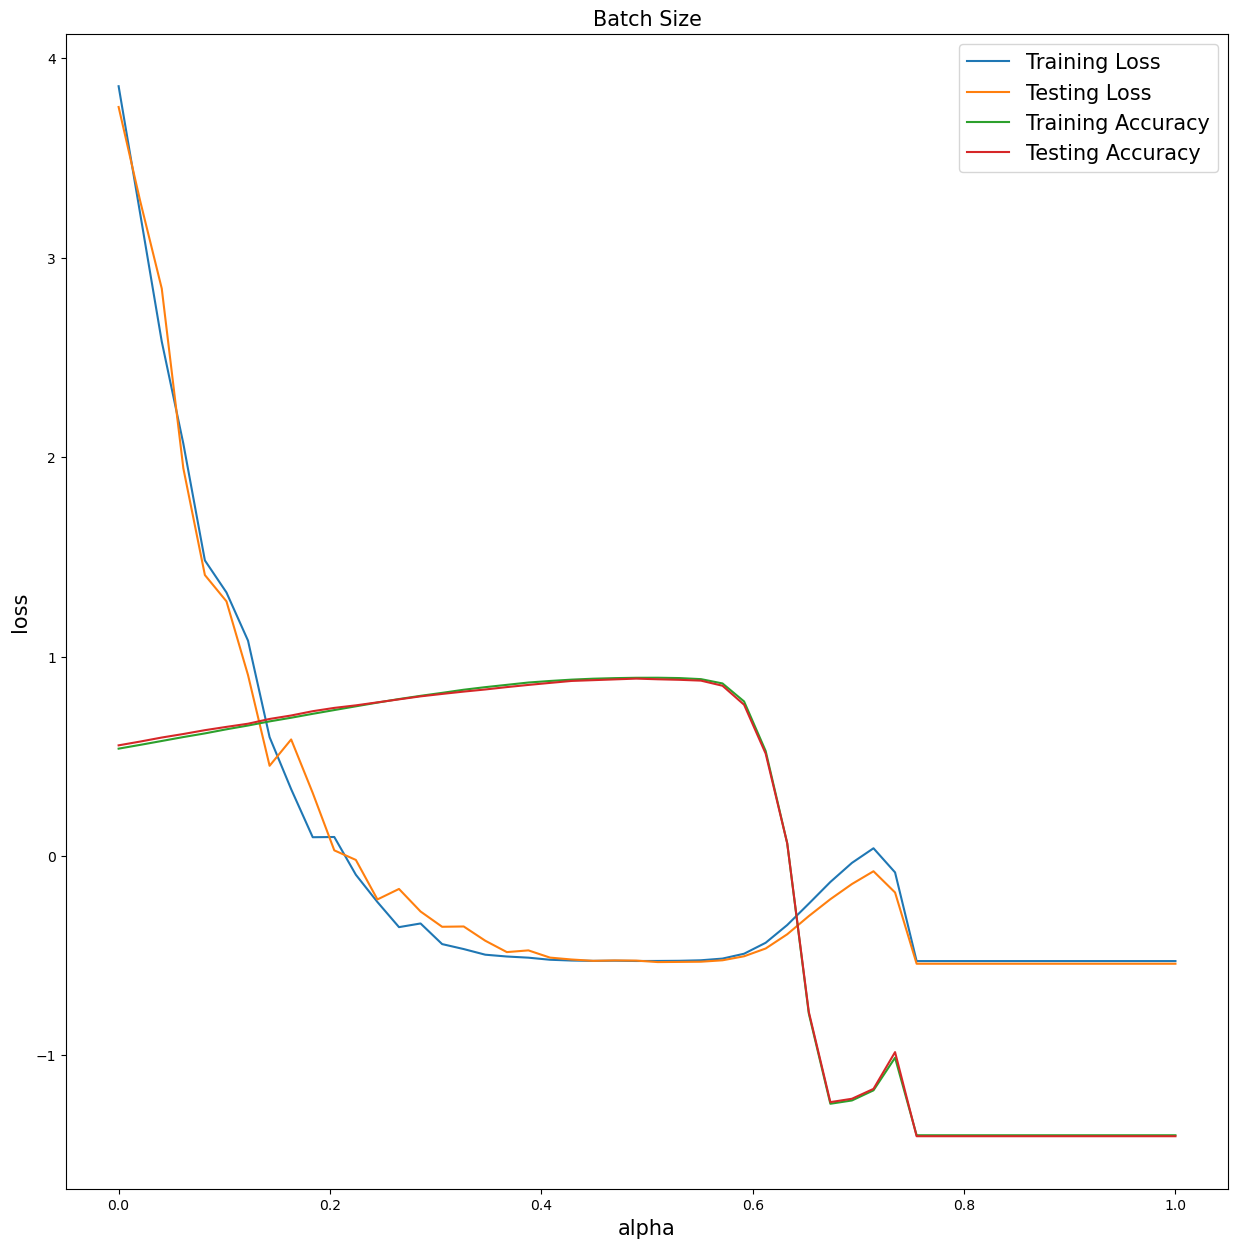

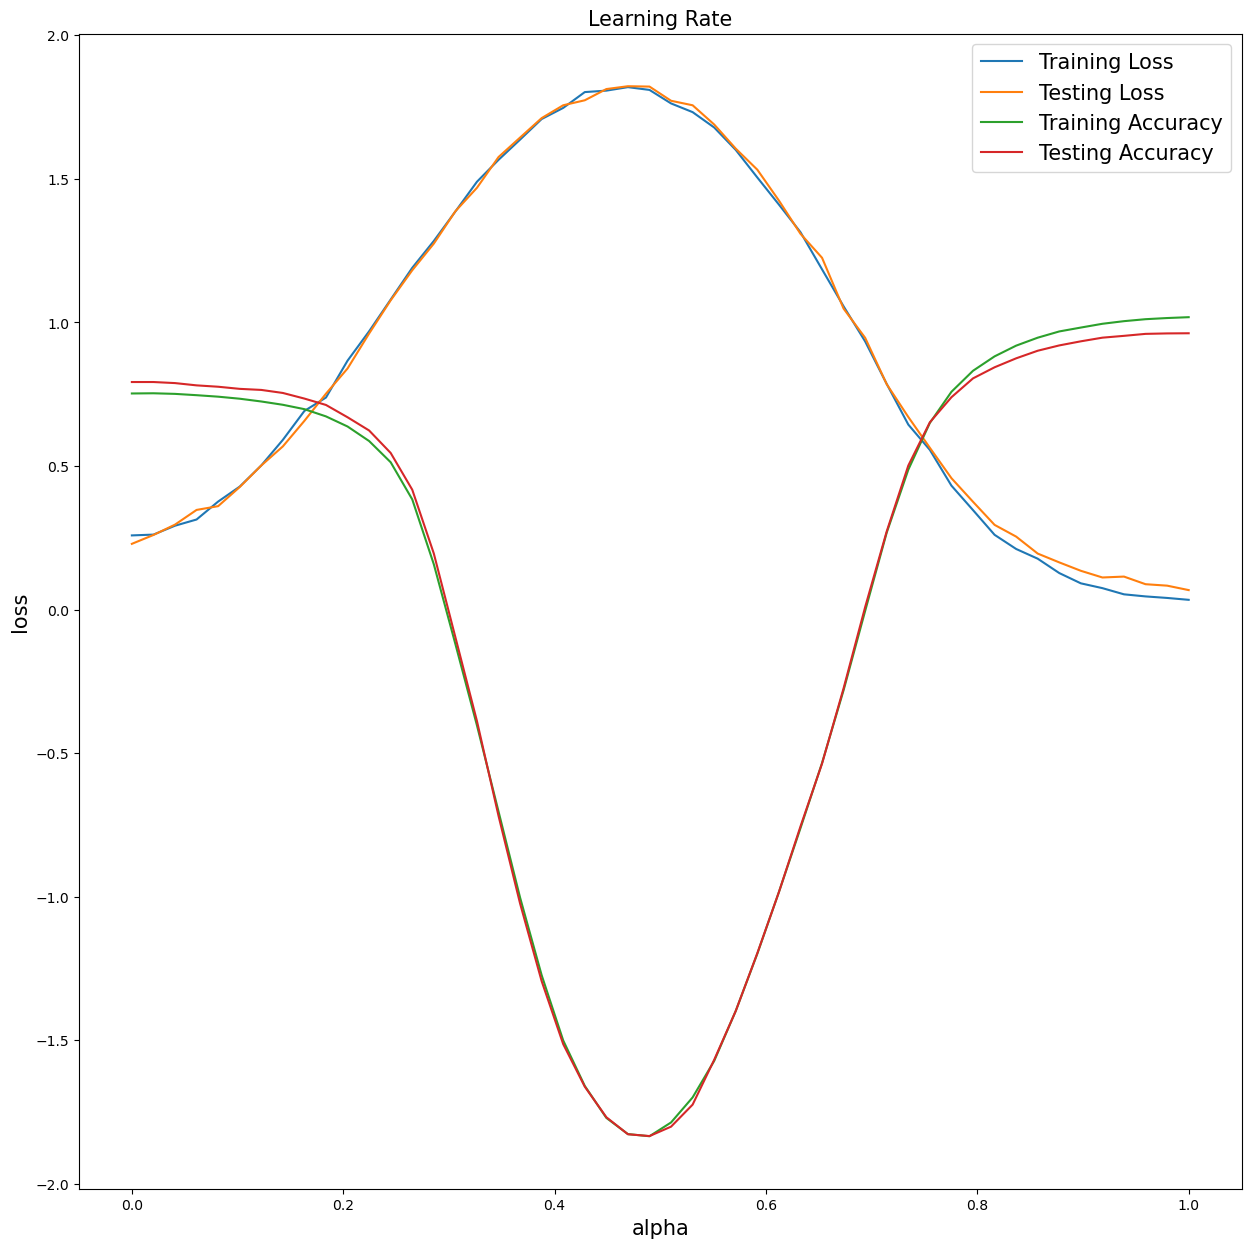

In [16]:
plt.figure(figsize=(15,15))
plt.plot(alpha_list,standardization(batch_train_loss), label='Training Loss')
plt.plot(alpha_list,standardization(batch_test_loss),label='Testing Loss')
plt.plot(alpha_list,standardization(batch_train_acc),label='Training Accuracy')
plt.plot(alpha_list,standardization(batch_test_acc),label='Testing Accuracy')
plt.xlabel('alpha',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.title('Batch Size',fontsize=15)
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(15,15))
plt.plot(alpha_list,(lr_train_loss), label='Training Loss')
plt.plot(alpha_list,(lr_test_loss), label='Testing Loss')
plt.plot(alpha_list,standardization(lr_train_acc), label='Training Accuracy')
plt.plot(alpha_list,standardization(lr_test_acc), label='Testing Accuracy')
plt.xlabel('alpha',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.title('Learning Rate',fontsize=15)
plt.legend(fontsize=15)
plt.show()

## 9. Part 2: Flatness vs Generalization 

In [17]:
[_,trainloss_1,testloss_1,accuracy_1,_,F_1] = train_MNIST(model_name=DNN_MNIST_N(28*28,10,20,10,10),Batch=10)
[_,trainloss_2,testloss_2,accuracy_2,_,F_2] = train_MNIST(model_name=DNN_MNIST_N(28*28,10,20,10,10),Batch=50)
[_,trainloss_3,testloss_3,accuracy_3,_,F_3] = train_MNIST(model_name=DNN_MNIST_N(28*28,10,20,10,10),Batch=100)
[_,trainloss_4,testloss_4,accuracy_4,_,F_4] = train_MNIST(model_name=DNN_MNIST_N(28*28,10,20,10,10),Batch=200)
[_,trainloss_5,testloss_5,accuracy_5,_,F_5] = train_MNIST(model_name=DNN_MNIST_N(28*28,10,20,10,10),Batch=1000)


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/20 Test set: Average loss: 5140.4750/508.4624, Accuracy: 8474/10000 (84.74%) lr=0.1
1/20 Test set: Average loss: 4340.8488/451.5248, Accuracy: 8601/10000 (86.01%) lr=0.1
2/20 Test set: Average loss: 4135.8618/353.4265, Accuracy: 8985/10000 (89.85%) lr=0.1
3/20 Test set: Average loss: 3966.5687/428.2202, Accuracy: 8613/10000 (86.13%) lr=0.1
4/20 Test set: Average loss: 3837.6247/444.7015, Accuracy: 8723/10000 (87.23%) lr=0.1
5/20 Test set: Average loss: 3796.7487/322.4521, Accuracy: 9001/10000 (90.01%) lr=0.1
6/20 Test set: Average loss: 3744.8574/379.4729, Accuracy: 8925/10000 (89.25%) lr=0.1
7/20 Test set: Average loss: 3725.1226/367.8878, Accuracy: 8907/10000 (89.07%) lr=0.1
8/20 Test set: Average loss: 3687.3285/381.7657, Accuracy: 8844/10000 (88.44%) lr=0.1
9/20 Test set: Average loss: 3586.9107/445.6295, 